In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
print("Training data shape :",train.shape)
print("Test data shape :",test.shape)

Training data shape : (1460, 81)
Test data shape : (1459, 80)


# SalePrice : our target variable
Lets have a look into its distribution

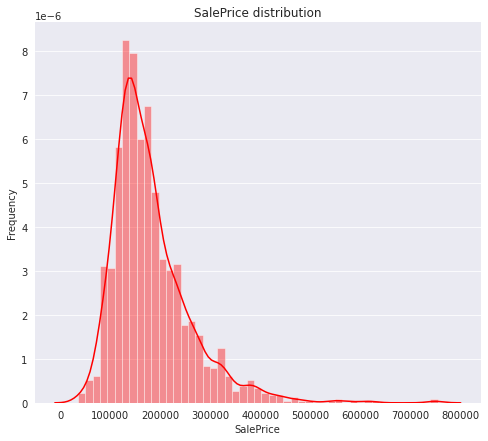

In [8]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="r");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [9]:
# Skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282



 mu = 180921.20 and sigma = 79415.29



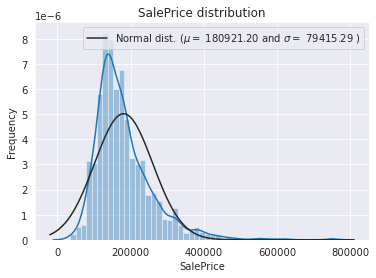

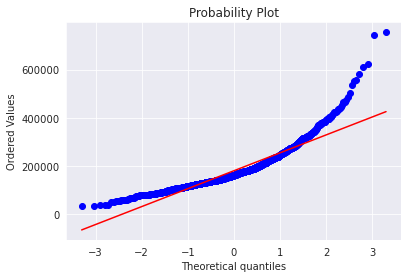

In [10]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

So its clear that our target variable is skewed towards right. So we have to apply some transformations to it to make it normally distributed otherwise it's going to be wrong

 Lets experiment with the **Logarithmic transformation** [log(1+x)] to SalePrice

In [11]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



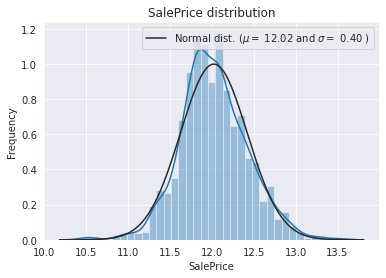

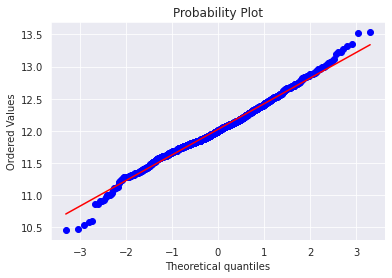

In [12]:
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

**Well now the target variable seems to be more or less Normally Distributed**

Lets detect & explore few outliers, to facilitate analysis

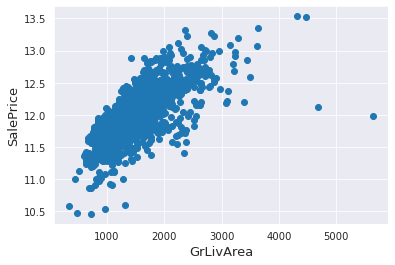

In [13]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

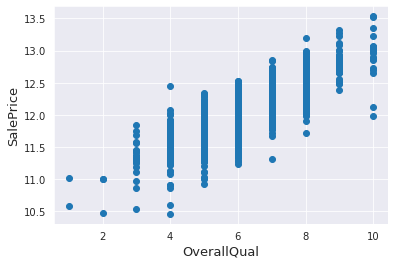

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

In [15]:
# Remove outliers
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# Feature Engineering

Lets concatenate the train & test data features , so that all faeture transformation tasks can be delivered through a pipeline

In [16]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [17]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

# Lets have a visualisation of the relationship between target & other numerical features

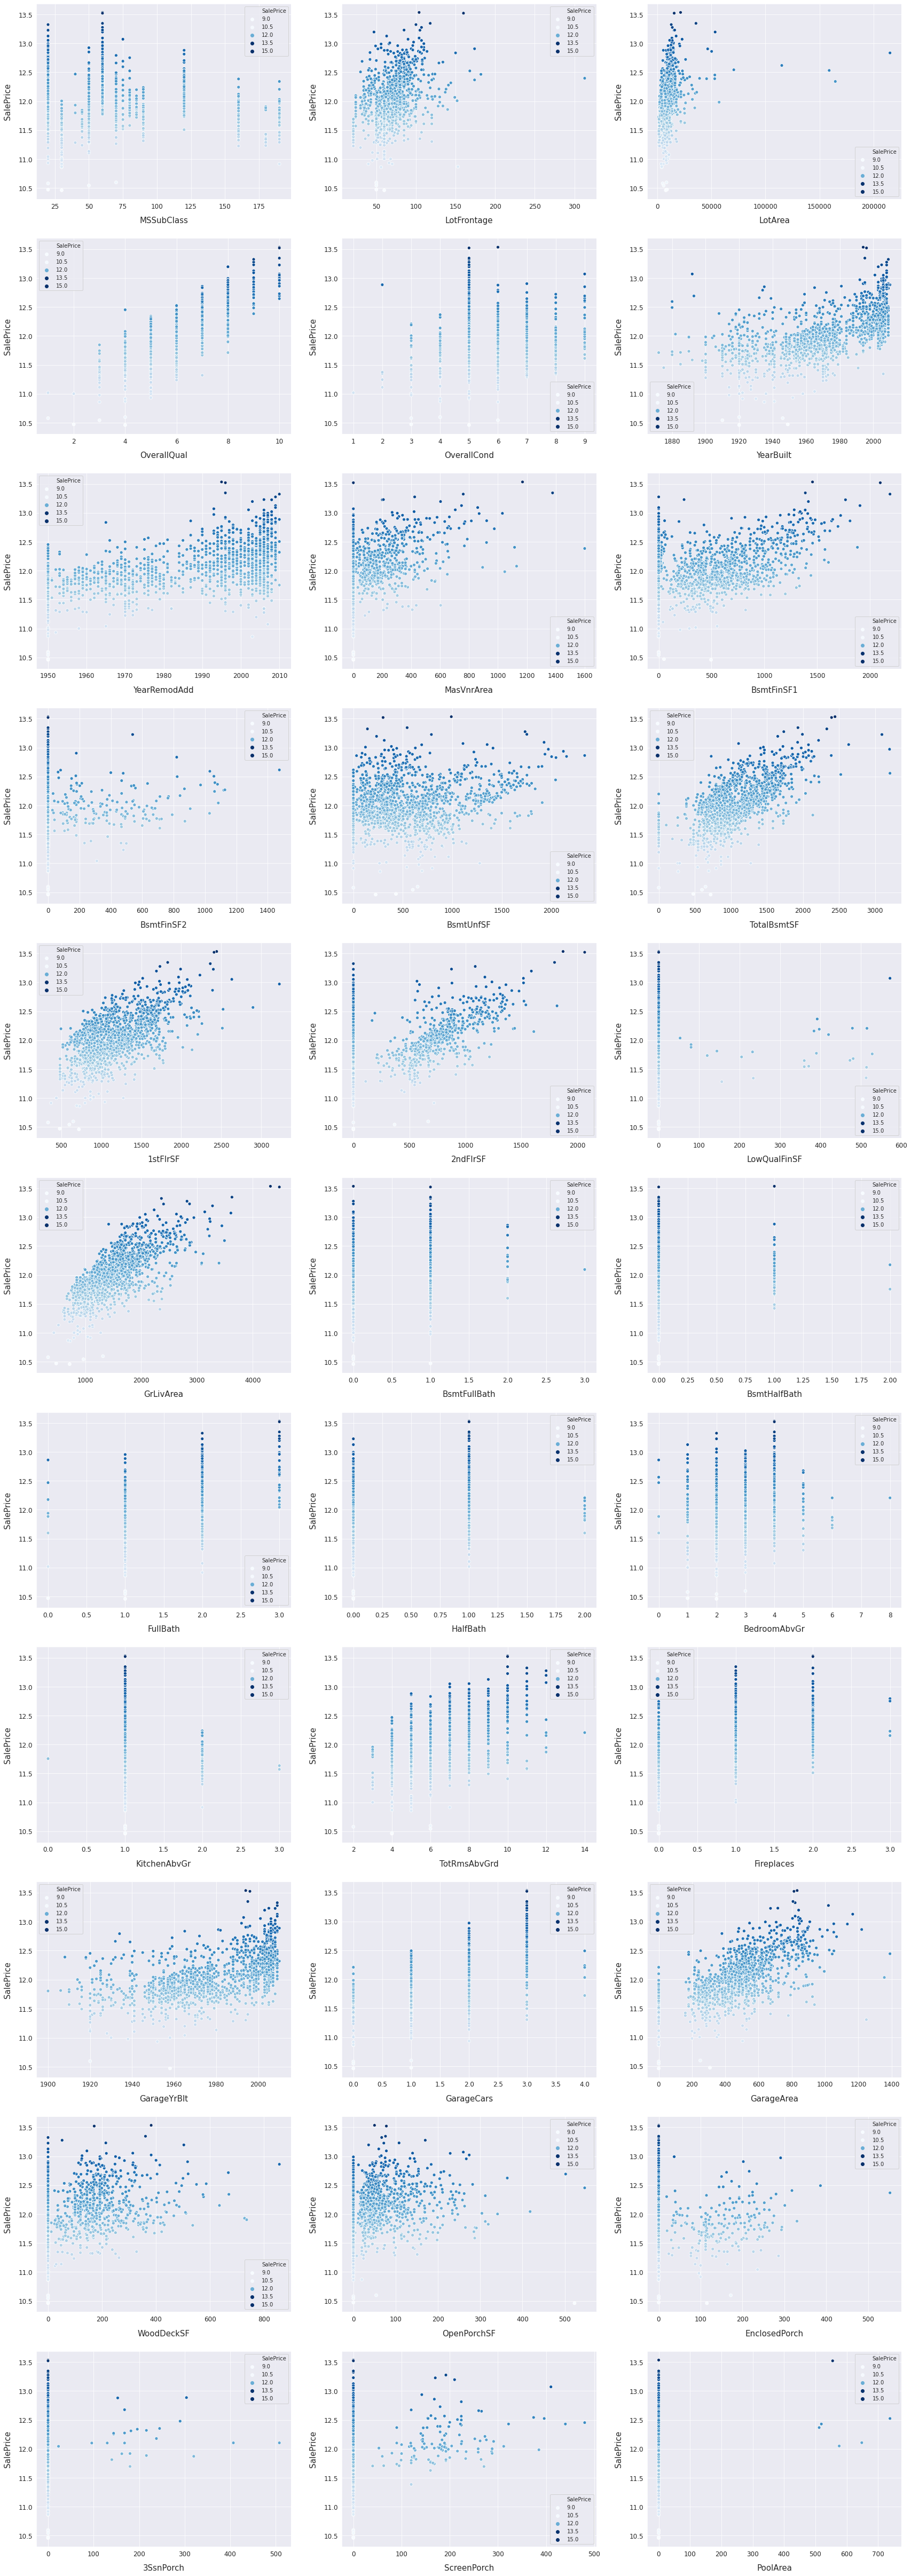

In [18]:
numeric = [col for col in train.columns if train[col].dtype in ['float64','int64','int32','float32','int16','float16']]
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(numeric), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})

**Handling Missing Entries**

In [19]:
all_data_na = (all_features.isnull().sum() / len(all_features)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


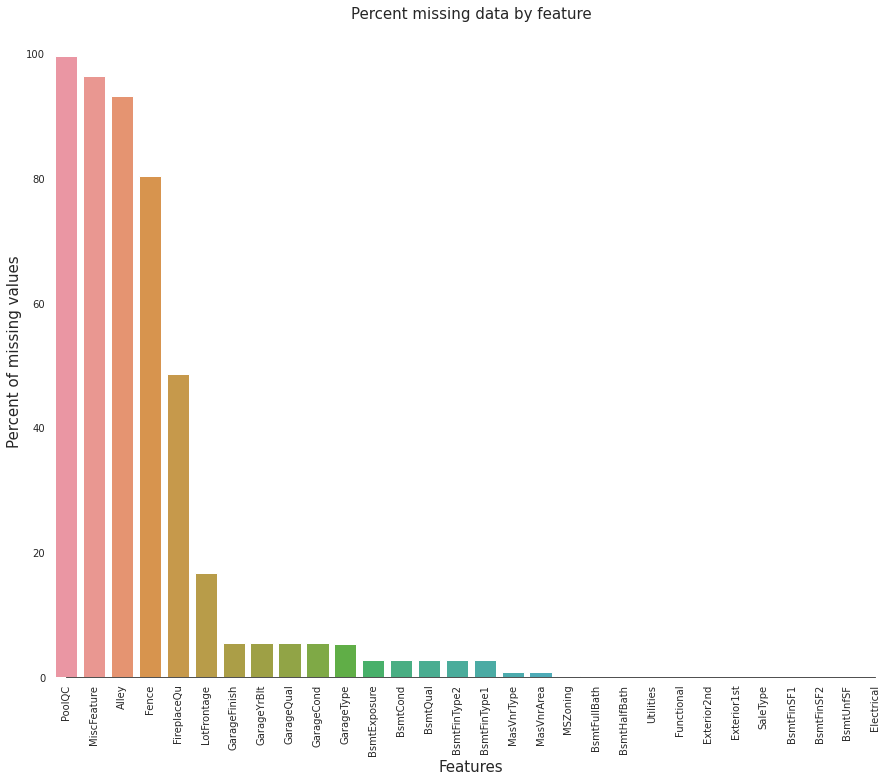

In [20]:
# Visualize missing values
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)

In [21]:
all_features['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [22]:
all_features.OverallCond.value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

![](http://)Hence the above features although seem numerical, it's not so. Similar is the case with 'YrSold','MoSold'

In [23]:
# convert them into strings 

all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)
all_features['OverallCond'] = all_features['OverallCond'].astype(str)

In [24]:
### Lets start imputing them ###
all_features["PoolQC"] = all_features["PoolQC"].fillna("None")
all_features["MiscFeature"] = all_features["MiscFeature"].fillna("None")
all_features["Alley"] = all_features["Alley"].fillna("None")
all_features["Fence"] = all_features["Fence"].fillna("None")
all_features["FireplaceQu"] = all_features["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_features["LotFrontage"] = all_features.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_features[col] = all_features[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_features[col] = all_features[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_features[col] = all_features[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_features[col] = all_features[col].fillna('None')
all_features["MasVnrType"] = all_features["MasVnrType"].fillna("None")
all_features["MasVnrArea"] = all_features["MasVnrArea"].fillna(0)
all_features['MSZoning'] = all_features['MSZoning'].fillna(all_features['MSZoning'].mode()[0])
all_features = all_features.drop(['Utilities'], axis=1)
all_features["Functional"] = all_features["Functional"].fillna("Typ")
all_features['Electrical'] = all_features['Electrical'].fillna(all_features['Electrical'].mode()[0])
all_features['KitchenQual'] = all_features['KitchenQual'].fillna(all_features['KitchenQual'].mode()[0])
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])
all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])
all_features['MSSubClass'] = all_features['MSSubClass'].fillna("None")


In [25]:
#Check remaining missing values if any 
all_features_na = (all_features.isnull().sum() / len(all_features)) * 100
all_features_na = all_features_na.drop(all_features_na[all_features_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_features_na})
missing_data.head()

,Missing Ratio


So there are no missing   values left

**Label Encoding some categorical variables**

In [26]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_features[c].values)) 
    all_features[c] = lbl.transform(list(all_features[c].values))

# shape        
print('Shape all_features: {}'.format(all_features.shape))

Shape all_features: (2917, 78)


Adding an extra feature : basement area + 1st floor area + 2nd floor area

In [27]:
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

**Handling Skewed Features**

In [28]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

In [29]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 27 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
LandSlope         4.973254
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
dtype: float64

**Box-Cox Transformation of highly-skewed features**

In [30]:
# Normalize skewed features
lam = 0.15
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i],lam)

Gettting dummy categorical features

In [31]:
all_features = pd.get_dummies(all_features)
print(all_features.shape)

(2917, 220)


In [32]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

# Time to separate again the Training & Test sets

In [33]:
xtrain = all_features.iloc[:len(train_labels), :]
xtest = all_features.iloc[len(train_labels):, :]
print(xtrain.shape); print(train_labels.shape); print(xtest.shape)

(1458, 220)
(1458,)
(1459, 220)


# Modelling

**Lets first define the evaluation metrics : RMSLE , RMSE**

In [34]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cross_val(model, X=xtrain):
    rmse = np.sqrt(-cross_val_score(model, xtrain, train_labels, scoring="neg_mean_squared_error", cv=KFold(n_splits=12, random_state=42, shuffle=True)))
    return rmse

In [35]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=6000,max_depth=4,min_child_weight=0,gamma=0.6,
                       subsample=0.7,colsample_bytree=0.7,objective='reg:squarederror',nthread=-1,scale_pos_weight=1,
                       seed=27,reg_alpha=0.00006,random_state=42)


# Light Gradient Boosting Regressor
#lightgbm = LGBMRegressor(objective='regression', num_leaves=6,learning_rate=0.01, n_estimators=7000,max_bin=200, 
 #                      bagging_fraction=0.8,bagging_freq=4, bagging_seed=8,feature_fraction=0.2,
  #                     feature_fraction_seed=8,min_sum_hessian_in_leaf = 11,verbose=-1,random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,learning_rate=0.01,max_depth=4,max_features='sqrt',
                                min_samples_leaf=15,min_samples_split=10,loss='huber',random_state=42) 

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,max_depth=15,min_samples_split=5,min_samples_leaf=5,
                          max_features=None,oob_score=True,random_state=42)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Ridge Regressor
ridge_alphas = [1e-10, 1e-8, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=KFold(n_splits=12, random_state=42, shuffle=True)))

# Stack up all the models above, optimized using xgboost
#stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),meta_regressor=xgboost,random_state=42)

stack_reg = StackingRegressor(estimators=[('xgboost',xgboost),('svr',svr),('ridge',ridge),('gbr',gbr),('rf',rf)], final_estimator=xgboost)    

**Fit the models**

In [36]:
print('stack_reg')
stack_reg_model = stack_reg.fit(np.array(xtrain), np.array(train_labels))

stack_reg


In [37]:
#print('lightgbm')
#lgb_data = lightgbm.fit(xtrain, train_labels)

In [38]:
print('xgboost')
xgb_data = xgboost.fit(xtrain, train_labels)

xgboost


In [39]:
print('Svr')
svr_data = svr.fit(xtrain, train_labels)

Svr


In [40]:
print('Ridge')
ridge_data = ridge.fit(xtrain, train_labels)

Ridge


In [41]:
print('RandomForest')
rf_data = rf.fit(xtrain, train_labels)

RandomForest


In [42]:
print('GradientBoosting')
gbr_data = gbr.fit(xtrain, train_labels)

GradientBoosting


**Lets visualize the cv-scores for each model**

In [43]:
scores = {}

#score = rmse_cross_val(lightgbm)
#print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
#scores['lgb'] = (score.mean(), score.std())

In [44]:
score = rmse_cross_val(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1120 (0.0195)


In [45]:
score = rmse_cross_val(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1115 (0.0158)


In [46]:
score = rmse_cross_val(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1375 (0.0156)


In [47]:
score = rmse_cross_val(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1118 (0.0167)


Lets apply blending of all models

In [48]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(xtrain):
    return ((0.2 * ridge_data.predict(xtrain)) + \
            (0.15 * svr_data.predict(xtrain)) + \
            (0.17 * gbr_data.predict(xtrain)) + \
            (0.1 * xgb_data.predict(xtrain)) + \
            (0.03 * rf_data.predict(xtrain)) + \
            (0.35 * stack_reg_model.predict(np.array(xtrain))))

In [49]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(xtrain))
scores['blended'] = (blended_score, 0)
print('RMSE score on train data:')
print(blended_score)

RMSE score on train data:
0.08256585083290294


Text(0.5, 1.0, 'Scores of Models')

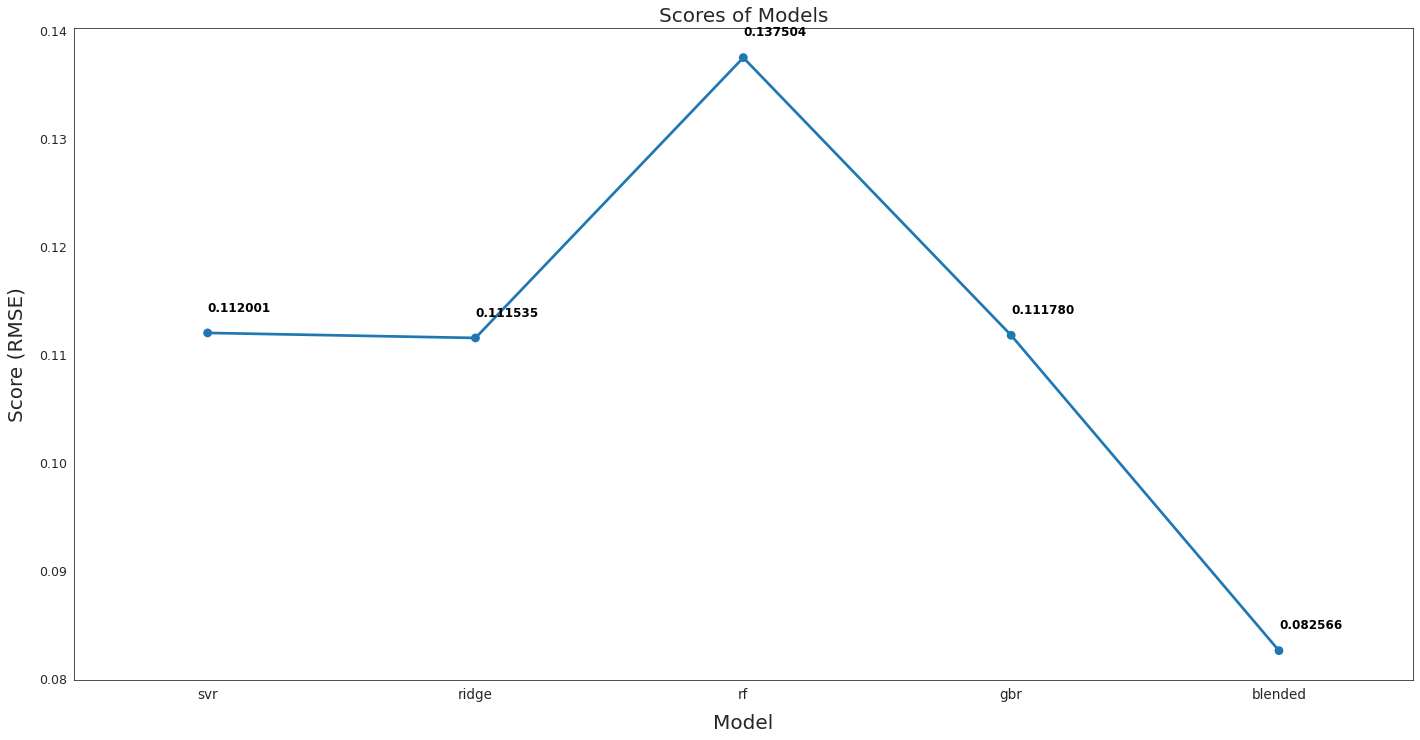

In [50]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)


In [51]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [52]:
# Append predictions from blended models
sample.iloc[:,1] = np.floor(np.expm1(blended_predictions(xtest)))

In [53]:
# Fix outlier predictions
#q1 = sample['SalePrice'].quantile(0.0045)
#q2 = sample['SalePrice'].quantile(0.99)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
sample.to_csv("my_submission.csv", index=False)